<a href="https://colab.research.google.com/github/SamuelBFG/cnn-based-autoencoder/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow==2.2

     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 460kB 38.5MB/s 
     |████████████████████████████████| 3.0MB 33.6MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow 2.0.0rc1
    Uninstalling tensorflow-2.0.0rc1:
      Successfully uninstalled tensorflow-2.0.0rc1


In [2]:
import os
import tensorflow as tf
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Lambda, BatchNormalization, Input, Conv1D, TimeDistributed, Flatten, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, TensorBoard, History, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as KR
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
from keras.optimizers import Adam

tf.compat.v1.disable_eager_execution()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_bits (InputLayer)      [(64, 10, 16)]            0         
_________________________________________________________________
e_1 (Conv1D)                 (64, 10, 256)             4352      
_________________________________________________________________
e_2 (BatchNormalization)     (64, 10, 256)             1024      
_________________________________________________________________
e_3 (Activation)             (64, 10, 256)             0         
_________________________________________________________________
e_7 (Conv1D)                 (64, 10, 256)             65792     
_________________________________________________________________
e_8 (BatchNormalization)     (64, 10, 256)             1024      
_________________________________________________________________
e_9 (Activation)             (64, 10, 256)             0     

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: loss improved from inf to 0.18314, saving model to ./model_LBC_4_10_1_9dB AWGN.h5
8960/8960 [==============================] - 4s 394us/sample - loss: 0.1831 - accuracy: 0.9676 - val_loss: 0.2367 - val_accuracy: 0.9375
Epoch 2/150
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0272 - accuracy: 1.0000
Epoch 00002: loss improved from 0.18314 to 0.02632, saving model to ./model_LBC_4_10_1_9dB AWGN.h5
8960/8960 [==============================] - 1s 97us/sample - loss: 0.0263 - accuracy: 1.0000 - val_loss: 0.2742 - val_accuracy: 0.9223
Epoch 3/150
8768/8960 [============================>.] - ETA: 0s - loss: 0.0113 - accuracy: 1.0000
Epoch 00003: loss improved from 0.02632 to 0.01122, saving model to ./model_LBC_4_10_1_9dB AWGN.h5
8960/8960 [==============================] - 1s 98us/sample - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.2180 - val_accuracy: 0.9271
Epoch 4/150
8832/8960 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000


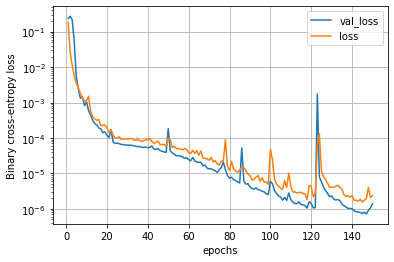

In [3]:
'''
 --- COMMUNICATION PARAMETERS ---
'''

# Bits per Symbol
k = 4

# Number of symbols
L = 10

# Channel Use
n = 1

# Effective Throughput
#  bits per symbol / channel use
R = L*k / n

# Eb/N0 used for training
train_Eb_dB = 9

# Noise Standard Deviation
noise_sigma = np.sqrt(1 / (2 * R * 10 ** (train_Eb_dB / 10)))


# Number of messages used for training, each size = k*L
batch_size = 64
nb_train_word = batch_size*200

'''
 --- GENERATING INPUT DATA ---
'''

# Generate training binary Data
train_data = np.random.randint(low=0, high=2, size=(nb_train_word, k * L))
# Used as labeled data
label_data = copy.copy(train_data)
train_data = np.reshape(train_data, newshape=(nb_train_word, L, k))

# Convert Binary Data to integer
tmp_array = np.zeros(shape=k)
for i in range(k):
    tmp_array[i] = 2 ** i
int_data = tmp_array[::-1]

# Convert Integer Data to one-hot vector
int_data = np.reshape(int_data, newshape=(k, 1))
one_hot_data = np.dot(train_data, int_data)
vec_one_hot = to_categorical(y=one_hot_data, num_classes=2 ** k)

# used as Label data
label_one_hot = copy.copy(vec_one_hot)

'''
 --- NEURAL NETWORKS PARAMETERS ---
'''

early_stopping_patience = 100

epochs = 150

optimizer = Adam(lr=0.001)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=early_stopping_patience)


# Learning Rate Control
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=5, min_lr=0.0001)

# Save the best results based on Training Set
modelcheckpoint = ModelCheckpoint(filepath='./' + 'model_LBC_' + str(k) + '_' + str(L) + '_' + str(n) + '_' + str(train_Eb_dB) + 'dB' + ' ' + 'AWGN' + '.h5',
                                  monitor='loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)


# Define Power Norm for Tx
def normalization(x):
    mean = KR.mean(x ** 2)
    return x / KR.sqrt(2 * mean)  # 2 = I and Q channels


# Define Channel Layers including AWGN and Flat Rayleigh fading
#  x: input data
#  sigma: noise std
def channel_layer(x, sigma):

    w = KR.random_normal(KR.shape(x), mean=0.0, stddev=sigma)

    return x + w


model_input = Input(batch_shape=(batch_size, L, 2 ** k), name='input_bits')

e = Conv1D(filters=256, strides=1, kernel_size=1, name='e_1')(model_input)
e = BatchNormalization(name='e_2')(e)
e = Activation('elu', name='e_3')(e)

e = Conv1D(filters=256, strides=1, kernel_size=1, name='e_7')(e)
e = BatchNormalization(name='e_8')(e)
e = Activation('elu', name='e_9')(e)

e = Conv1D(filters=2 * n, strides=1, kernel_size=1, name='e_10')(e)  # 2 = I and Q channels
e = BatchNormalization(name='e_11')(e)
e = Activation('linear', name='e_12')(e)

e = Lambda(normalization, name='power_norm')(e)

# AWGN channel
y_h = Lambda(channel_layer, arguments={'sigma': noise_sigma}, name='channel_layer')(e)

# Define Decoder Layers (Receiver)
d = Conv1D(filters=256, strides=1, kernel_size=1, name='d_1')(y_h)
d = BatchNormalization(name='d_2')(d)
d = Activation('elu', name='d_3')(d)

d = Conv1D(filters=256, strides=1, kernel_size=1, name='d_7')(d)
d = BatchNormalization(name='d_8')(d)
d = Activation('elu', name='d_9')(d)

# Output One hot vector and use Softmax to soft decoding
model_output = Conv1D(filters=2 ** k, strides=1, kernel_size=1, name='d_10', activation='softmax')(d)

# Build System Model
sys_model = Model(model_input, model_output)
encoder = Model(model_input, e)

# Print Model Architecture
sys_model.summary()

# Compile Model
sys_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# print('encoder output:', '\n', encoder.predict(vec_one_hot, batch_size=batch_size))

print('starting train the NN...')
start = time.clock()

# TRAINING
mod_history = sys_model.fit(vec_one_hot, label_one_hot,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.3, callbacks=[modelcheckpoint,reduce_lr])

end = time.clock()

print('The NN has trained ' + str(end - start) + ' s')


# Plot the Training Loss and Validation Loss
hist_dict = mod_history.history

val_loss = hist_dict['val_loss']
loss = hist_dict['loss']
# acc = hist_dict['acc']
# val_acc = hist_dict['val_acc']
print('loss:',loss)
print('val_loss:',val_loss)

epoch = np.arange(1, epochs + 1)

plt.semilogy(epoch,val_loss,label='val_loss')
plt.semilogy(epoch, loss, label='loss')

plt.legend(loc=0)
plt.grid('true')
plt.xlabel('epochs')
plt.ylabel('Binary cross-entropy loss')

plt.show()

start simulation ...4_10_1


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Eb/N0 =  0
BLock Error Rate =  0.01184375


Eb/N0 =  1
BLock Error Rate =  0.00440625


Eb/N0 =  2
BLock Error Rate =  0.00134375


Eb/N0 =  3
BLock Error Rate =  0.0003515625


Eb/N0 =  4
BLock Error Rate =  5.46875e-05


Eb/N0 =  5
BLock Error Rate =  1.5625e-05


Eb/N0 =  6
BLock Error Rate =  0.0


Eb/N0 =  7
BLock Error Rate =  0.0


Eb/N0 =  8
BLock Error Rate =  0.0


Eb/N0 =  9
BLock Error Rate =  0.0


Eb/N0 =  10
BLock Error Rate =  0.0


Eb/N0 =  11
BLock Error Rate =  0.0


Eb/N0 =  12
BLock Error Rate =  0.0


Eb/N0 =  13
BLock Error Rate =  0.0


Eb/N0 =  14
BLock Error Rate =  0.0


Eb/N0 =  15
BLock Error Rate =  0.0


Eb/N0 =  16
BLock Error Rate =  0.0


Eb/N0 =  17
BLock Error Rate =  0.0


Eb/N0 =  18
BLock Error Rate =  0.0


Eb/N0 =  19
BLock Error Rate =  0.0


Eb/N0 =  20
BLock Error Rate =  0.0


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] 
 [0.01184375, 0.00440625, 0.00134375, 0.0003515625, 5.46875e-05, 1.5625e-05, 0.0, 0.0, 0.0,

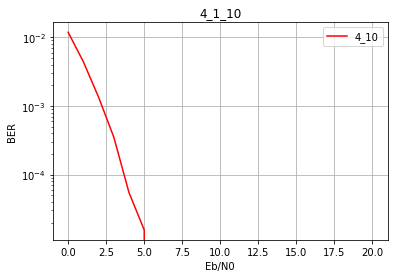

In [4]:
num_of_sym = nb_train_word
Vec_Eb_N0 = []
Bit_error_rate = []

'''
 --- GENERATING INPUT DATA ---
'''

# Initialize information Data 0/1
in_sym = np.random.randint(low=0, high=2, size=(num_of_sym, k * L))
label_data = copy.copy(in_sym)
in_sym = np.reshape(in_sym,newshape=(num_of_sym,L,k))

# Convert Binary Data to integer
tmp_array = np.zeros(shape=k)
for i in range(k):
    tmp_array[i]=2**i
int_data = tmp_array[::-1]

# Convert Integer Data to one-hot vector
int_data = np.reshape(int_data,newshape=(k,1))
one_hot_data = np.dot(in_sym,int_data)
# print(one_hot_data)
vec_one_hot = to_categorical(y=one_hot_data, num_classes=2**k)

# used as Label data
label_one_hot = copy.copy(vec_one_hot)


# Define Channel Layers including AWGN and Flat Rayleigh fading
def channel_layer(x,sigma):
    w = KR.random_normal(KR.shape(x), mean=0.0, stddev=sigma)

    return x + w


def normalization(x):
    mean = KR.mean(x ** 2)
    return x / KR.sqrt(2*mean)  # 2 = number of NN into the channel


print('start simulation ...' + str(k) + '_' + str(L)+'_'+str(n))



'''
 --- DEFINE THE Neural Network(NN) ---
'''

# Eb_N0 in dB
for Eb_N0_dB in range(0,21):

    # Noise Sigma at this Eb
    noise_sigma = np.sqrt(1 / (2 * R * 10 ** (Eb_N0_dB / 10)))

    # Define Encoder Layers (Transmitter)
    model_input = Input(batch_shape=(None, L, 2 ** k), name='input_bits')

    e = Conv1D(filters=256, strides=1, kernel_size=1, name='e_1')(model_input)
    e = BatchNormalization(name='e_2')(e)
    e = Activation('elu', name='e_3')(e)



    e = Conv1D(filters=256, strides=1, kernel_size=1, name='e_7')(e)
    e = BatchNormalization(name='e_8')(e)
    e = Activation('elu', name='e_9')(e)

    e = Conv1D(filters=2 * n, strides=1, kernel_size=1, name='e_10')(e)  # 2 = I and Q channels
    e = BatchNormalization(name='e_11')(e)
    e = Activation('linear', name='e_12')(e)

    e = Lambda(normalization, name='power_norm')(e)

    # AWGN channel
    y_h = Lambda(channel_layer, arguments={'sigma': noise_sigma}, name='channel_layer')(e)

    # Define Decoder Layers (Receiver)
    d = Conv1D(filters=256, strides=1, kernel_size=1, name='d_1')(y_h)
    d = BatchNormalization(name='d_2')(d)
    d = Activation('elu', name='d_3')(d)


    d = Conv1D(filters=256, strides=1, kernel_size=1, name='d_7')(d)
    d = BatchNormalization(name='d_8')(d)
    d = Activation('elu', name='d_9')(d)

    # Output One hot vector and use Softmax to soft decoding
    model_output = Conv1D(filters=2 ** k, strides=1, kernel_size=1, name='d_10', activation='softmax')(d)

    # Build the model
    model = Model(inputs=model_input, outputs=model_output)

    encoder = Model(model_input,e)
    # Load Weights from the trained NN
    model.load_weights('./' + 'model_LBC_' + str(k) + '_' + str(L) + '_' + str(n) + '_' + str(train_Eb_dB) + 'dB' + ' ' + 'AWGN' + '.h5',
                       by_name=False)

    '''
    RUN THE NN
    '''

    # RUN Through the Model and get output
    decoder_output = model.predict(vec_one_hot, batch_size=batch_size)
    encoder_output = encoder.predict(vec_one_hot, batch_size=batch_size)

    '''
     --- CALULATE BLER ---
    '''

    # Decode One-Hot vector
    position = np.argmax(decoder_output, axis=2)
    tmp = np.reshape(position,newshape=one_hot_data.shape)

    error_rate = np.mean(np.not_equal(one_hot_data,tmp))


    print('Eb/N0 = ', Eb_N0_dB)
    print('BLock Error Rate = ', error_rate)

    print('\n')

    # Store The Results
    Vec_Eb_N0.append(Eb_N0_dB)
    Bit_error_rate.append(error_rate)



'''
PLOTTING
'''
# Print BER
# print(Bit_error_rate)

print(Vec_Eb_N0, '\n', Bit_error_rate)

with open('BLER_model_LBC_'+str(k)+'_'+str(n)+'_'+str(L)+'_AWGN'+'.txt', 'w') as f:
    print(Vec_Eb_N0, '\n', Bit_error_rate, file=f)
f.closed

# Plot BER Figure
plt.semilogy(Vec_Eb_N0, Bit_error_rate, color='red')
label = [str(k) + '_' + str(L)]
plt.legend(label, loc=0)
plt.xlabel('Eb/N0')
plt.ylabel('BER')
plt.title(str(k) + '_' + str(n)+'_'+str(L))
plt.grid('true')
plt.show()